# Tutorial: Epidemiology Models


## Advanced Macroeconomics: Numerical Methods  (MIE37)



H.W. Heathcote: epidemiologic models are *deterministic models for infectious diseases which are spread by direct person-to-person contact in a population*.

This kind of models has been used since by a few decades by economist, for matters that have nothing to do with health.

- diffusion of information, or opinions on social medias
- asset prices and fads
- expectation formation for macroeconomic outcomes (ex: *The Epidemiology of Macroeconomic Expectations* by Chris Carroll)

Epidemiologic models have two features that depart from standard economic models:

- Agent's behaviour does not take the full system into account, an is irrational in the sense that it isn't forward looking. Instead, an agent is given a behavioural heuristic.
- The transitions of the whole system can be determined without solving for complex interactions first.

Understanding why these two assumptions are very costly for economists will keep us busy during a big part of the course. Here we just consider two simple models as small programming exercises.

### Simple SIR model

There is a continuum of agents of mass $1$. Each agent can be either "Susceptible" (S), "Infected" (I) or "Recovered" (R).
In each period, one agent meets another agent drawn randomly.
During a meeting Susceptible agents who meet an infected agent, will always catch the disease (or the fad) but are not contagious. Infected agents, have a probability $\pi$ of being recovered. Nothing happens to Recovered agents who meet other people. No distinction is made between recovering as a healthy or a dead person.

We're interested in the evolution in the number infected persons, both the speed of infection and the total amount of infected people in every period.

__Write down the transition equations for $n_I$, the number of infected people, for $n_R$ the number of recovered people and $n_S$ the number of susceptible people.__



n_I = (1- $\pi$) * n_I + n_I * n_S <br />
n_R = n_R + $\pi$ * n_I<br />
n_S = n_S - n_I * n_S 

__Compute the transition function `f` for the vector state $s_t$ returning $s_{t+1}$.__

In [1]:
function f(s,π0)
    return [(1-π0+s[3])*s[1], s[2]+π0*s[1], s[3]*(1-s[1])]
end

f (generic function with 1 method)

__Compute the transitions over $T$ periods. Plot the result using Plots.jl. (bonus: check against closed form solution)__



In [2]:
using DataFrames
using Plots

In [3]:
function plot_transitions(n_periods::Int64,s0, π0::Float64)
    states = s0
    for k in 1:n_periods-1
        s0 = f(s0,π0)
        push!(states,s0...)
    end
    states = reshape(states, (3, n_periods))
    plot(states[1,:], ylabel = "n_I")
    plot!(states[2,:], ylabel = "n_R")
    plot!(states[3,:], ylabel = "n_S")
end

plot_transitions (generic function with 1 method)

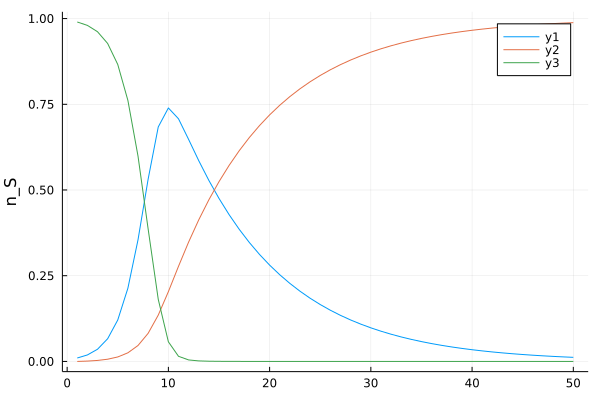

In [4]:
plot_transitions(50,[0.01,0.,0.99],0.1)


__We now assume a Susceptible person who meets an infected one has a probability $\mu$ of catching the disease. Update the transition function. Update function $f$ and write a function of $\mu$, $\pi$ which returns the simulation. Compare different values of the parameters. How would you interpret "social distancing"? How would you choose parameters $\Pi$ and $\mu$__ 

In [5]:
function f(s,μ,π0)
    return [(1-π0+s[3]*μ)*s[1], s[2]+π0*s[1], s[3]*(1-s[1]*μ)]
end

f (generic function with 2 methods)

In [6]:
function plot_transitions(n_periods::Int64,s0,μ::Float64,π0::Float64)
    states = s0
    for k in 1:n_periods-1
        s0 = f(s0,μ,π0)
        push!(states,s0...)
    end
    states = reshape(states, (3, n_periods))
    plot(states[1,:], ylabel = "n_I")
    plot!(states[2,:], ylabel = "n_R")
    plot!(states[3,:], ylabel = "n_S")
end

plot_transitions (generic function with 2 methods)

$\pi$ = 0.1
$\mu$ = 0.8

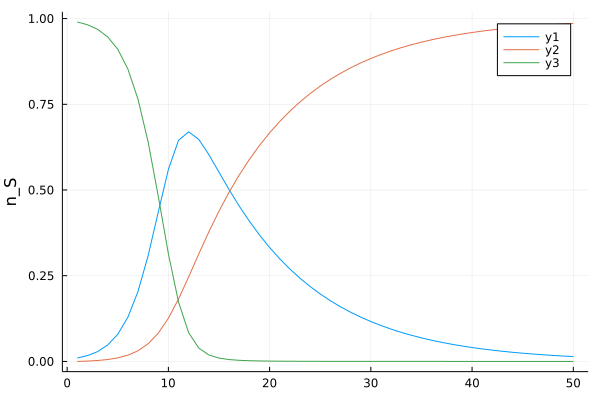

In [7]:
plot_transitions(50,[0.01,0.,0.99], 0.8, 0.1)

$\pi$ = 0.2
$\mu$ = 0.8

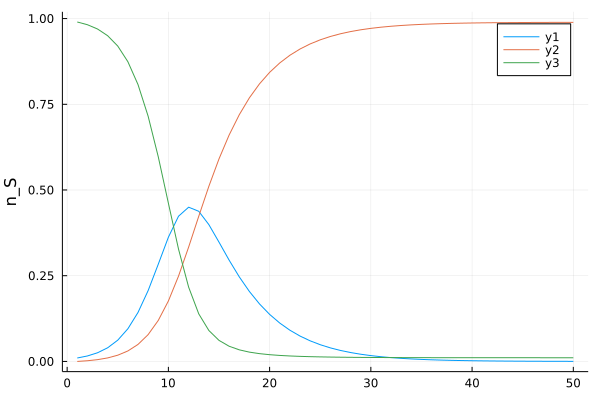

In [8]:
plot_transitions(50,[0.01,0.,0.99], 0.8, 0.2)

$\pi$ = 0.1
$\mu$ = 0.6

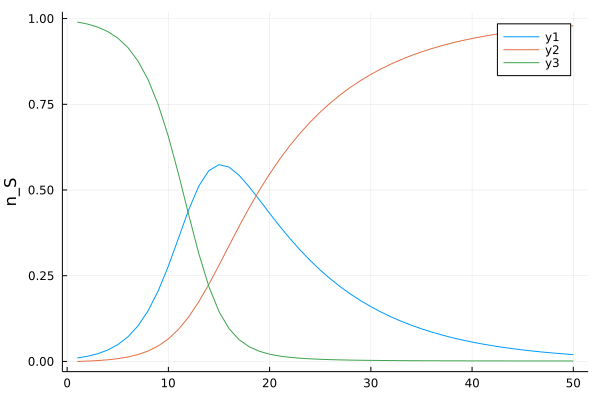

In [9]:
plot_transitions(50,[0.01,0.,0.99], 0.6, 0.1)

Social distancing reduces the probability to catch the disease and therefore $\mu$. Therefore, it will have the effect of spreading the contamination wave in the time.

### A Spatial SIR model

We now consider another version of the model where agents evolve in the space $\mathcal{S}=[0,1]\times[0,1]$. There are $N\in\mathbb{N}$ agent. At any date, each agent $n \in [0,1]$  is located at $(x_n,y_n)\in \mathcal{S}$.

Each agent moves follows a random walk bounded by $\mathcal{S}$:
$$x_t = \min(\max( x_{t-1} + \epsilon_t, 0), 1)$$
$$y_t = \min(\max( y_{t-1} + \eta_t, 0), 1)$$
where $\epsilon_t$ and $\eta_t$ are both normally distributed with standard deviation $\sigma$.

At any date, the individual state of an agent is $s_t=(x_t, y_t, h_t)$ where $h_t$ is either "S", "I" or "R". $v_t$ denotes the states of all agents (for instance $v_t=(s_{n,t})_n$. The health status of each agent is updated in the following way:

- Agents $R$ stay $R$.
- Agents $I$ have probability $\pi$ to become $R$. They stay $I$ otherwise.
- An agent of type $S$ in position $(x,y)$ has a probability $prob(x,y,S)$ to be infected that is $\mu$ if there is another infected agent within a radius $r>0$.


__Define a type `Agent`, which holds the type of an agent. The state of the whole system will be held in a `Vector[Agent]` type.__



In [10]:
struct Agent
    x::Float64
    y::Float64
    h::String
end

__Write a function `spatial_transition(S::Vector{Agent})::Vector{Agent}` to compute the transition of the positions. Write another function `random_guess(T=100)` which simulates for $T$ periods in order to find a good initial guess.__



In [11]:
using Random, Distributions

In [12]:
function is_close_neighbour(S::Vector{Agent}, k::Int64, j::Int64, r::Float64)
    return (S[k].x-S[j].x)^2 + (S[k].y-S[j].y)^2 < r^2
end

function has_infected_neighbour(S::Vector{Agent}, k::Int64, r::Float64)
    for i in 1:length(S)
        if is_close_neighbour(S, k, i, r) && S[i].h == "I"
            return true
        end
    end
    return false
end

function new_h(S::Vector{Agent}, k::Int64, r::Float64, Π::Float64, μ::Float64)
    if S[k].h == "R"
        return "R"
    elseif S[k].h == "I"
        return (rand()< Π ? "R" : "I")
    else
        return (has_infected_neighbour(S,k,r) ? "I" : "S")
    end
end

new_h (generic function with 1 method)

In [13]:
function spatial_transition(S::Vector{Agent}, σ::Float64, r::Float64, Π::Float64, μ::Float64)
    ϵ, η = rand(Normal(0, σ), 2)
    return [Agent(min(max(S[k].x + ϵ, 0),1), min(max(S[k].y + η, 0),1), new_h(S, k, r, Π, μ)) for k in 1:length(S)]
end

spatial_transition (generic function with 1 method)

In [103]:
function random_guess(S0::Vector{Agent}; T=100, σ=1., r=0.3, Π=0.2, μ=0.9)
    timeline = []
    push!(timeline, S0)
    for t in 1:T-1
        S0 = spatial_transition(S0, σ, r, Π, μ)
        push!(timeline, S0)
    end
    return timeline
end

random_guess (generic function with 1 method)

__Write a function `show_population` to plot all agents with different colors for different health status.__



In [83]:
function show_population(S::Vector{Agent})
    SS = []
    SI = []
    SR = []
    for k in 1:length(S)
        if S[k].h=="R"
            push!(SR,S[k])
        elseif S[k].h=="I"
            push!(SI,S[k])
        else
            push!(SS,S[k])
        end
    end
    scatter([SS[k].x for k in 1:length(SS)], [SS[k].y for k in 1:length(SS)], color="green", label = "S")
    scatter!([SI[k].x for k in 1:length(SI)], [SI[k].y for k in 1:length(SI)], color="blue", label = "I")
    scatter!([SR[k].x for k in 1:length(SR)], [SR[k].y for k in 1:length(SR)], color="red", label = "R")
end
    

show_population (generic function with 1 method)

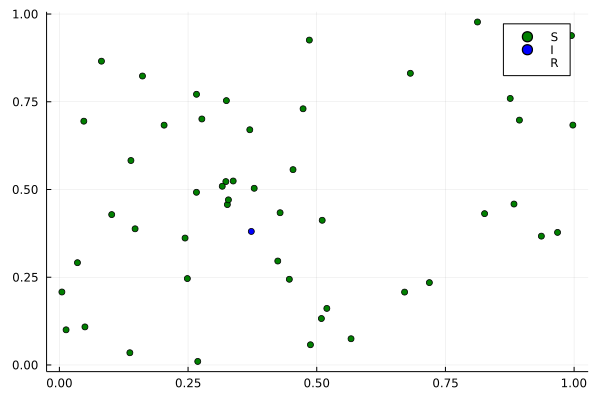

In [111]:
k = 1
N = 50
x = rand(N)
y = rand(N)
h = shuffle([("S" for i in 1:N-k)...,("I" for j in 1:k)...])
S0 = [Agent(x[i],y[i],h[i]) for i in 1:N]
show_population(S0)


__Write a function `evolve(S::Vector[Agent])::Vector[Agent]` which takes the population in a given state and returns the same population with updated health status.__



Already done above in spatial_transition. 

__Write a function `simulate(S0::Vector[Agent], k=1)` to simulate the economy starting from an initially random position with `k` infected individuals. The returned object should be of type `Vector[Vector[Agent]]`.__



It's random_guess...

__Compute statistics along a simulated path for $n_I$, $n_S$, $n_R$. Plot and compare with the basic SIR model__

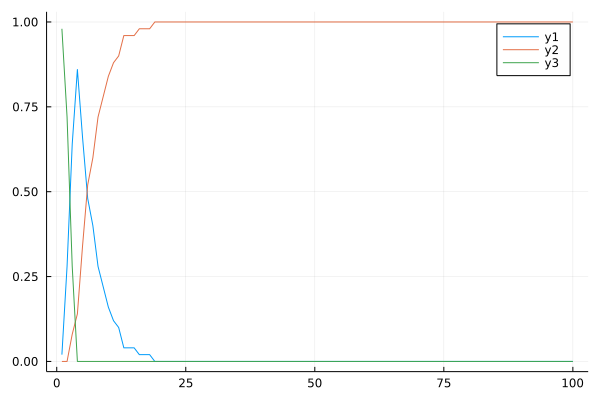

In [110]:
simulation = random_guess(S0)
n_I = []
n_S = []
n_R = []
for k in 1:length(simulation)
    ni = 0
    ns = 0
    nr = 0
    for i in 1:N
        if simulation[k][i].h=="I"
            ni+=1/N
        elseif simulation[k][i].h=="R"
            nr+=1/N
        else
            ns+= 1/N
        end
    end
    push!(n_I,ni)
    push!(n_S,ns)
    push!(n_R,nr)
end
plot(1:100,[n_I,n_R,n_S])


### Additional questions

Have fun by trying to answer one of these questions:
- change probability of infection so that it depends on the number of infected people in the vincinity (with some suitable functional formulation for)
- compute an animation of the transition
- compute an interactive visualisation (with `Interact.jl` if available)